<a href="https://colab.research.google.com/github/utk468/micro_organism_deeplearning/blob/main/micro_organism_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
import shutil
from shutil import copytree, rmtree
from pathlib import Path

In [ ]:
def prepare_data(source_dir, target_dir, split_ratio=0.8):

    if os.path.exists(target_dir):
        rmtree(target_dir)
    os.makedirs(target_dir)

    classes = os.listdir(source_dir)
    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        if os.path.isdir(cls_path):
            images = os.listdir(cls_path)
            train_size = int(len(images) * split_ratio)

            os.makedirs(os.path.join(target_dir, 'train', cls))
            os.makedirs(os.path.join(target_dir, 'validation', cls))

            for i, img in enumerate(images):
                src_path = os.path.join(cls_path, img)
                if os.path.isfile(src_path):
                    if i < train_size:
                        dest_path = os.path.join(target_dir, 'train', cls, img)
                    else:
                        dest_path = os.path.join(target_dir, 'validation', cls, img)
                    shutil.copy(src_path, dest_path)

source_dir = "/content/drive/MyDrive/Colab Notebooks/Micro_Organism"
target_dir = "organized_dataset"
prepare_data(source_dir, target_dir)

In [ ]:

train_dir = os.path.join(target_dir, 'train')
validation_dir = os.path.join(target_dir, 'validation')

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)



Found 636 images belonging to 8 classes.
Found 163 images belonging to 8 classes.


In [9]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation="softmax"),
])


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)


accuracy = model.evaluate(validation_generator)[1] * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.1489 - loss: 2.5499 - val_accuracy: 0.2577 - val_loss: 2.0431
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2229 - loss: 2.2049 - val_accuracy: 0.2883 - val_loss: 1.9080
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.2736 - loss: 1.9596 - val_accuracy: 0.3313 - val_loss: 1.8010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3399 - loss: 1.8751 - val_accuracy: 0.3620 - val_loss: 1.7247
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.3247 - loss: 1.8353 - val_accuracy: 0.3804 - val_loss: 1.6690
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.3902 - loss: 1.6976 - val_accuracy: 0.4172 - val_loss: 1.6102
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4048 - loss: 1.5979 - val_accuracy: 0.4294 - val_loss: 1.5585
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4732 - loss: 1.5159 - val_accuracy: 0.4417 - val_loss: 1.5177
Ep

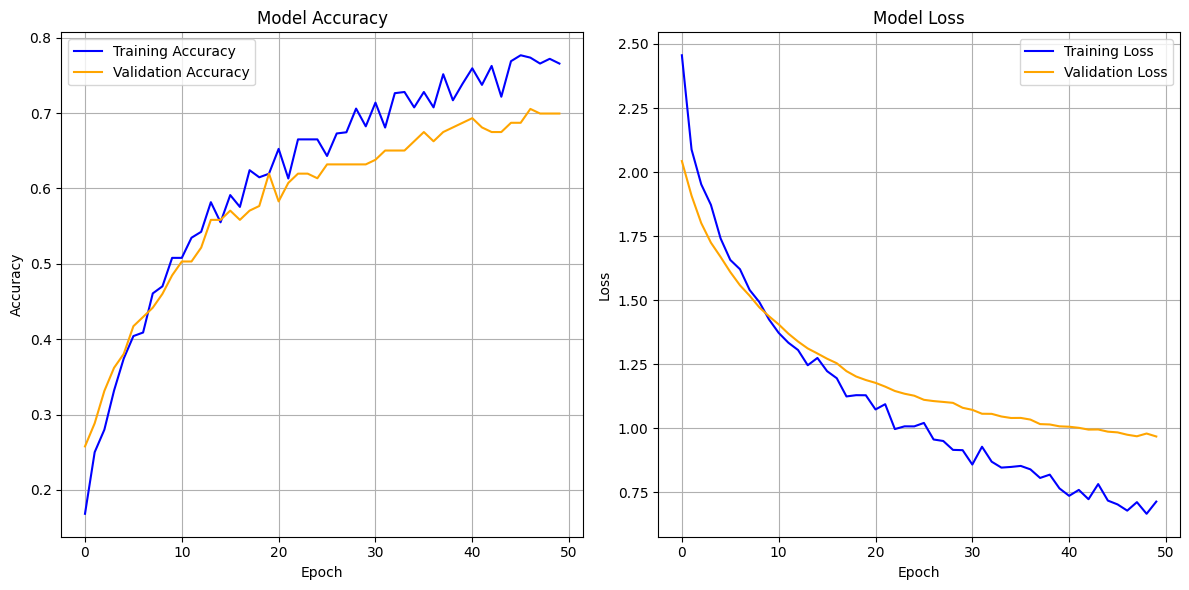

In [11]:
import matplotlib.pyplot as plt


def plot_learning_curves(history):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

